In [1]:
# Pandas dataframe
import pandas as pd
from pandas import DataFrame

# Scikit-Learn
import sklearn 
from sklearn import datasets, linear_model, metrics, tree
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_validate, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score

# Models
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import (BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, 
RandomForestRegressor, AdaBoostRegressor)
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
        
import joblib
from matplotlib import pyplot as plt
import numpy as np
import os
from tqdm import tqdm

In [2]:
df_abs = pd.read_csv("../hao/dataset_scaled_abs.csv")
df_abs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 76 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Unnamed: 0                                    205 non-null    int64  
 1   in_amount_mmol                                205 non-null    float64
 2   p_amount_mmol                                 205 non-null    float64
 3   sol_amount_ml                                 205 non-null    float64
 4   TOP_amount_mmol                               205 non-null    float64
 5   acid_amount_mmol                              205 non-null    float64
 6   amine_amount_mmol                             205 non-null    float64
 7   thiol_amount_mmol                             205 non-null    float64
 8   zinc_amount_mmol                              205 non-null    float64
 9   other_amount_mmol                             205 non-null    flo

In [3]:
#Checks the column names, and ensures that they do not have any leading or trailing spaces
df_abs.columns = df_abs.columns.str.strip()

In [4]:
# Input for ML models

input_col = ['in_amount_mmol',
             'p_amount_mmol',
             'sol_amount_ml',
             'TOP_amount_mmol',
             'acid_amount_mmol',
             'amine_amount_mmol',
             'thiol_amount_mmol',
             'zinc_amount_mmol',
             'other_amount_mmol',
             'total_volume_ml',
             'temp_c',
             'time_min',
             'x0_chloroindium oxalate',
             'x0_indium acetate',
             'x0_indium bromide',
             'x0_indium chloride',
             'x0_indium iodide',
             'x0_indium myristate',
             'x0_indium oxalate',
             'x0_indium palmitate',
             'x0_indium trifluoroacetate',
             'x0_indium tris(N,N-diisopropylacetamidinato)',
             'x1_bis(trimethylsilyl)phosphine',
             'x1_phosphine gas',
             'x1_phosphorus trichloride',
             'x1_sodium phosphide',
             'x1_tris(diethylamino)phosphine',
             'x1_tris(dimethylamino)phosphine',
             'x1_tris(trimethylgermyl)phosphine',
             'x1_tris(trimethylsilyl)phosphine',
             'x1_white phosphorus',
             'x2_4-ethylpyridine',
             'x2_None',
             'x2_dimethylformamide',
             'x2_mesitylene',
             'x2_octadecene',
             'x2_toluene',
             'x3_None',
             'x3_trioctylphosphine',
             'x4_None',
             'x4_lauric acid',
             'x4_myristic acid',
             'x4_oleic acid',
             'x4_palmitic acid',
             'x4_stearic acid',
             'x5_None',
             'x5_dioctylamine',
             'x5_dodecylamine',
             'x5_hexadecylamine',
             'x5_octylamine',
             'x5_oleylamine',
             'x6_None',
             'x6_dodecanethiol',
             'x7_None',
             'x7_zinc acetate',
             'x7_zinc bromide',
             'x7_zinc chloride',
             'x7_zinc iodide',
             'x7_zinc octanoate',
             'x7_zinc oleate',
             'x7_zinc stearate',
             'x7_zinc undecylenate',
             'x8_None',
             'x8_acetic acid',
             'x8_copper bromide',
             'x8_superhydride',
             'x8_oleic acid',
             'x8_tetrabutylammonium myristate',
             'x8_trioctylamine',
             'x8_trioctylphosphine oxide',
             'x8_water',
             'x8_zinc iodide'
            ]

output_col = ['abs_nm']

X = df_abs[input_col]

Y = df_abs[output_col]

In [5]:
# Splitting dataset for training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=45, shuffle=True)

# Hyper parameter tuning
## Ensemble regressors

### Bagging

In [7]:
%%time

#sklearn random search over n iterations
#define ranges of paramaters to tune
#the internet tunes these parameters for bagging

params = {'n_estimators': range(10,1001)}

#n_jobs runs jobs in parallel, verbose prints updates in command line
rs_bag = RandomizedSearchCV(BaggingRegressor(), param_distributions=params, n_iter=100, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_bag.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_bag.best_score_)
print('Best Parameters : ',rs_bag.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best MAE Score Through Random Search : -36.258
Best Parameters :  {'n_estimators': 829}
CPU times: user 3.33 s, sys: 179 ms, total: 3.51 s
Wall time: 2min 31s


Mean absolute error = 27.269 nm


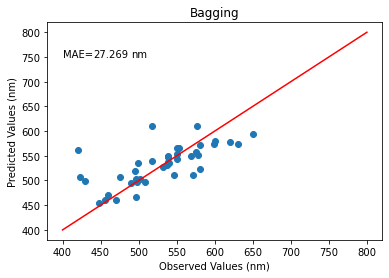

In [8]:
#using random search parameters
B_regr = BaggingRegressor(n_estimators=829)
B_regr.fit(X_train, np.ravel(Y_train))
            
B_Y_pred = B_regr.predict(X_test)
            
B_mae = mean_absolute_error(Y_test, B_Y_pred)
print("Mean absolute error =", round(B_mae,3), 'nm')

plt.figure()
plt.title("Bagging")
plt.plot(Y_test, B_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(B_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Random Forest

In [10]:
%%time

#sklearn random search

params = {'n_estimators': range(100,1001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions=params, n_iter=100, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_rf.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_rf.best_score_)
print('Best Parameters : ',rs_rf.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best MAE Score Through Random Search : -36.093
Best Parameters :  {'n_estimators': 678}
CPU times: user 2.77 s, sys: 180 ms, total: 2.94 s
Wall time: 2min 21s


Mean absolute error = 27.41 nm


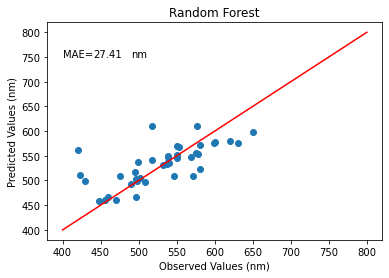

In [16]:
#using grid search parameters
RF_regr = RandomForestRegressor(n_estimators=678)
RF_regr.fit(X_train, np.ravel(Y_train))
            
RF_Y_pred = RF_regr.predict(X_test)
            
RF_mae = mean_absolute_error(Y_test, RF_Y_pred)
print("Mean absolute error =", round(RF_mae,3), 'nm')

plt.figure()
plt.title("Random Forest")
plt.plot(Y_test, RF_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(RF_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Decision Tree

In [14]:
%%time

#sklearn random search

params = {'min_samples_split': range(2,100),
          'min_samples_leaf':range(1,100)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_dt = RandomizedSearchCV(DecisionTreeRegressor(), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_dt.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_dt.best_score_)
print('Best Parameters : ',rs_dt.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -42.976
Best Parameters :  {'min_samples_split': 17, 'min_samples_leaf': 19}
CPU times: user 3.15 s, sys: 119 ms, total: 3.27 s
Wall time: 9.09 s


Mean absolute error = 40.945 nm


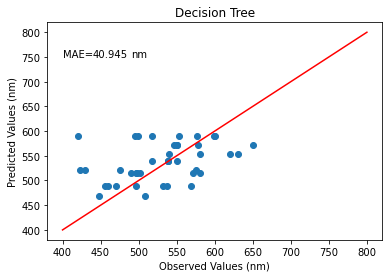

In [18]:
#using grid search parameters
DT_regr = DecisionTreeRegressor(min_samples_leaf=17, min_samples_split=19)
DT_regr.fit(X_train, np.ravel(Y_train))
            
DT_Y_pred = DT_regr.predict(X_test)
            
DT_mae = mean_absolute_error(Y_test, DT_Y_pred)
print("Mean absolute error =", round(DT_mae,3), 'nm')

plt.figure()
plt.title("Decision Tree")
plt.plot(Y_test, DT_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(DT_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Extra Trees

In [39]:
%%time

#sklearn random search

params = {'n_estimators': range(100,1001),
          'min_samples_split':range(2,10),
         'min_samples_leaf': range(1,10)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_et = RandomizedSearchCV(ExtraTreesRegressor(), param_distributions=params, n_iter=500, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_et.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_et.best_score_)
print('Best Parameters : ',rs_et.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best MAE Score Through Random Search : -37.299
Best Parameters :  {'n_estimators': 315, 'min_samples_split': 4, 'min_samples_leaf': 1}
CPU times: user 11.6 s, sys: 1.24 s, total: 12.8 s
Wall time: 10min 13s


In [40]:
%%time

#after first optimisation, now looking for best random state

params = {'random_state':range(1,1001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_et = RandomizedSearchCV(ExtraTreesRegressor(n_estimators=315, min_samples_split=4, min_samples_leaf=1), 
                           param_distributions=params, n_iter=500, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_et.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_et.best_score_)
print('Best Parameters : ',rs_et.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best MAE Score Through Random Search : -37.087
Best Parameters :  {'random_state': 828}
CPU times: user 8.93 s, sys: 529 ms, total: 9.46 s
Wall time: 11min 12s


Mean absolute error = 22.42 nm


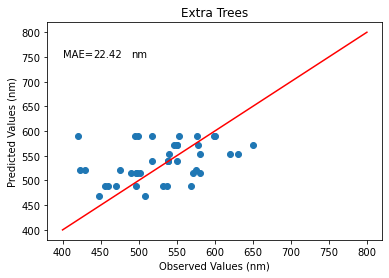

In [40]:
ET_regr = ExtraTreesRegressor(n_estimators=315, min_samples_split=4, min_samples_leaf=1, random_state=828)
            
ET_regr.fit(X_train, np.ravel(Y_train))
            
ET_Y_pred = ET_regr.predict(X_test)
            
ET_mae = mean_absolute_error(Y_test, ET_Y_pred)
print("Mean absolute error =", round(ET_mae,3), 'nm')

plt.figure()
plt.title("Extra Trees")
plt.plot(Y_test, DT_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(ET_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Ada Boost

In [19]:
%%time

#sklearn random search

params = {'n_estimators': range(50,501),
          'learning_rate':range(1,11),
         'loss':['linear', 'square', 'exponential']}

#n_jobs runs jobs in parallel, verbose prints updates
rs_ab = RandomizedSearchCV(AdaBoostRegressor(), param_distributions=params, n_iter=100, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_ab.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_ab.best_score_)
print('Best Parameters : ',rs_ab.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best MAE Score Through Random Search : -36.671
Best Parameters :  {'n_estimators': 128, 'loss': 'square', 'learning_rate': 1}
CPU times: user 1.52 s, sys: 40.4 ms, total: 1.56 s
Wall time: 36.6 s


Mean absolute error = 33.022 nm


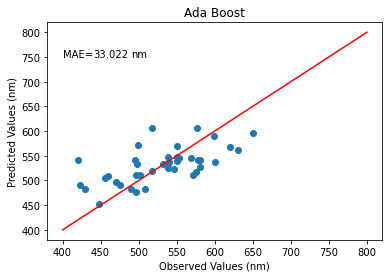

In [28]:
AB_regr = AdaBoostRegressor(n_estimators=128, loss='square', learning_rate=1)
            
AB_regr.fit(X_train, np.ravel(Y_train))
AB_Y_pred = AB_regr.predict(X_test)
            
AB_mae = mean_absolute_error(Y_test, AB_Y_pred)
print("Mean absolute error =", round(AB_mae,3), 'nm')

plt.figure()
plt.title("Ada Boost")
plt.plot(Y_test, AB_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(AB_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Gradient Boosting

In [21]:
%%time

#sklearn random search

params = {'n_estimators': range(100,1001),
          'min_samples_split':range(2,21),
         'min_samples_leaf': range(1,11),
         'max_depth':range(3,31)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_gb = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=params, n_iter=100, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_gb.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_gb.best_score_)
print('Best Parameters : ',rs_gb.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best MAE Score Through Random Search : -36.173
Best Parameters :  {'n_estimators': 210, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 3}
CPU times: user 1.4 s, sys: 103 ms, total: 1.51 s
Wall time: 57.6 s


Mean absolute error = 25.199 nm


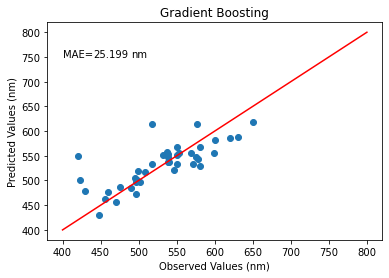

In [31]:
GB_regr = GradientBoostingRegressor(n_estimators=210, min_samples_split=4, min_samples_leaf=2, max_depth=3)
            
GB_regr.fit(X_train, np.ravel(Y_train))
GB_Y_pred = GB_regr.predict(X_test)
            
GB_mae = mean_absolute_error(Y_test, GB_Y_pred)
print("Mean absolute error =", round(GB_mae,3), 'nm')

plt.figure()
plt.title("Gradient Boosting")
plt.plot(Y_test, GB_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(GB_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

## Others

### Linear Regression

Mean absolute error = 21438664489993.355 nm


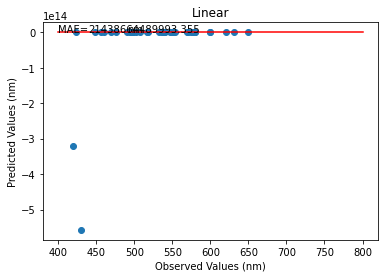

In [23]:
#using random search parameters
Linear_regr = LinearRegression()
Linear_regr.fit(X_train, np.ravel(Y_train))
            
Linear_Y_pred = Linear_regr.predict(X_test)
            
Linear_mae = mean_absolute_error(Y_test, Linear_Y_pred)
print("Mean absolute error =", round(Linear_mae,3), 'nm')

plt.figure()
plt.title("Linear")
plt.plot(Y_test, Linear_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(Linear_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Lasso

In [24]:
%%time

#sklearn random search over n iterations

params = {'max_iter': range(1000,10001),
         'selection': ['cyclic', 'random']}

#n_jobs runs jobs in parallel, verbose prints updates
rs_lasso = RandomizedSearchCV(Lasso(), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_lasso.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_lasso.best_score_)
print('Best Parameters : ',rs_lasso.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -44.752
Best Parameters :  {'selection': 'random', 'max_iter': 7405}
CPU times: user 3.24 s, sys: 103 ms, total: 3.34 s
Wall time: 10.7 s


Mean absolute error = 34.567 nm


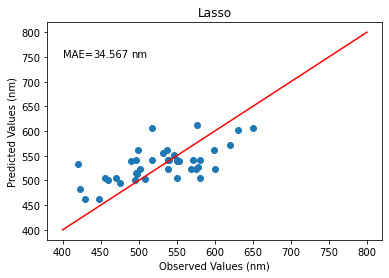

In [33]:
#using random search parameters
Lasso_regr = Lasso(selection='random', max_iter=7405)
Lasso_regr.fit(X_train, np.ravel(Y_train))
            
Lasso_Y_pred = Lasso_regr.predict(X_test)
            
Lasso_mae = mean_absolute_error(Y_test, Lasso_Y_pred)
print("Mean absolute error =", round(Lasso_mae,3), 'nm')

plt.figure()
plt.title("Lasso")
plt.plot(Y_test, Lasso_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(Lasso_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### ElasticNet

In [26]:
%%time

#sklearn random search over n iterations

params = {'max_iter': range(1000,10001),
         'selection': ['cyclic', 'random']}

#n_jobs runs jobs in parallel, verbose prints updates
rs_en = RandomizedSearchCV(ElasticNet(), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_en.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_en.best_score_)
print('Best Parameters : ',rs_en.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -46.315
Best Parameters :  {'selection': 'random', 'max_iter': 1016}
CPU times: user 3.06 s, sys: 144 ms, total: 3.21 s
Wall time: 9.62 s


Mean absolute error = 40.775 nm


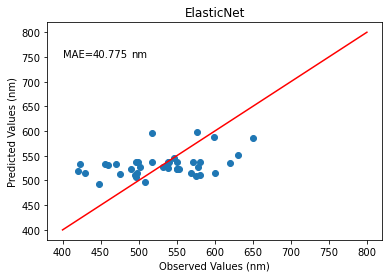

In [35]:
#using random search parameters
EN_regr = ElasticNet(selection='random', max_iter=1016)
EN_regr.fit(X_train, np.ravel(Y_train))
            
EN_Y_pred = EN_regr.predict(X_test)
            
EN_mae = mean_absolute_error(Y_test, EN_Y_pred)
print("Mean absolute error =", round(EN_mae,3), 'nm')

plt.figure()
plt.title("ElasticNet")
plt.plot(Y_test, EN_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(EN_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Ridge

Mean absolute error = 33.308 nm


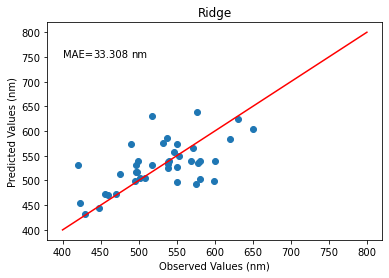

In [37]:
#using random search parameters
Ridge_regr = Ridge()
Ridge_regr.fit(X_train, np.ravel(Y_train))
            
Ridge_Y_pred = Ridge_regr.predict(X_test)
            
Ridge_mae = mean_absolute_error(Y_test, Ridge_Y_pred)
print("Mean absolute error =", round(Ridge_mae,3), 'nm')

plt.figure()
plt.title("Ridge")
plt.plot(Y_test, Ridge_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(Ridge_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### SVR kernel='linear'

In [32]:
%%time

#sklearn random search over n iterations

params = {'degree':range(1,10),
         'cache_size':range(200,2001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_svrlin = RandomizedSearchCV(SVR(kernel='linear'), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_svrlin.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_svrlin.best_score_)
print('Best Parameters : ',rs_svrlin.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -46.755
Best Parameters :  {'degree': 3, 'cache_size': 1227}
CPU times: user 2.69 s, sys: 94.3 ms, total: 2.78 s
Wall time: 10 s


Mean absolute error = 39.908 nm


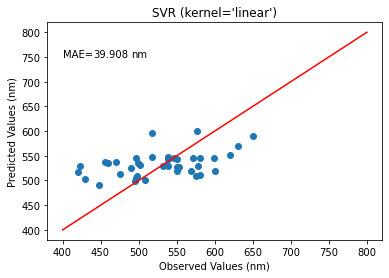

In [39]:
#using random search parameters
SVRlin_regr = SVR(kernel='linear', degree=3, cache_size=1227)
SVRlin_regr.fit(X_train, np.ravel(Y_train))
            
SVRlin_Y_pred = SVRlin_regr.predict(X_test)
            
SVRlin_mae = mean_absolute_error(Y_test, SVRlin_Y_pred)
print("Mean absolute error =", round(SVRlin_mae,3), 'nm')

plt.figure()
plt.title("SVR (kernel='linear')")
plt.plot(Y_test, SVRlin_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(SVRlin_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### SVR kernel='rbf'

In [34]:
%%time

#sklearn random search over n iterations

params = {'degree':range(1,10),
         'cache_size':range(200,2001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_svrrbf = RandomizedSearchCV(SVR(kernel='rbf'), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_svrrbf.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_svrrbf.best_score_)
print('Best Parameters : ',rs_svrrbf.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -49.821
Best Parameters :  {'degree': 2, 'cache_size': 504}
CPU times: user 3.92 s, sys: 192 ms, total: 4.11 s
Wall time: 13.2 s


Mean absolute error = 44.715 nm


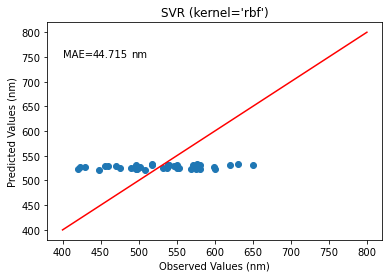

In [35]:
#using random search parameters
SVRrbf_regr = SVR(kernel='rbf', degree=2, cache_size=504)
SVRrbf_regr.fit(X_train, np.ravel(Y_train))
            
SVRrbf_Y_pred = SVRrbf_regr.predict(X_test)
            
SVRrbf_mae = mean_absolute_error(Y_test, SVRrbf_Y_pred)
print("Mean absolute error =", round(SVRrbf_mae,3), 'nm')

plt.figure()
plt.title("SVR (kernel='rbf')")
plt.plot(Y_test, SVRrbf_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(SVRrbf_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

## Conclusion

Extra Trees gave the best performance, **n_estimators=466, min_samples_split=3, min_samples_leaf=1, random_state=609**

## Saving model

In [64]:
ET_regr = ExtraTreesRegressor(n_estimators=466, min_samples_split=3, min_samples_leaf=1, random_state=609)

ET_regr.fit(X_train, np.ravel(Y_train))
ET_Y_pred = ET_regr.predict(X_test)

joblib.dump(ET_regr, "./model_aug_abs_ExtraTrees.joblib")

['./model_aug_abs_ExtraTrees.joblib']